In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def u_prime(x, lam_vec=np.zeros(3)):
    return ((x+5) - 10 * (lam_vec[0])**2)**2 / (0.1 + lam_vec[1]**4) + lam_vec[2] * np.sin(x*10)**2


def u(x, lam=0):
    """1D lambda argument"""
    return u_prime(x, lam * np.ones(3))

x = np.linspace(-10,10,1000)

def get_p(lam):
    q = np.exp(-u(x, lam))
    Z = np.trapz(q, x)
    p = q / Z
    return p

In [346]:
lambda_labels = [r"$\lambda_0$: location", r"$\lambda_1$: scale", r"$\lambda_2$: spikiness"]

In [370]:
import seaborn.apionly as sns

colors = sns.color_palette("coolwarm", 10)

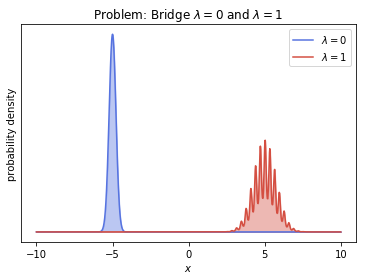

In [371]:
for i, lam in enumerate(np.linspace(0,1,10)):
    if i == 0 or i == 9:
        plt.plot(x,get_p(lam),label=r"$\lambda=$"+str(int(lam)), color=colors[i])
        plt.fill_between(x, get_p(lam), alpha=0.4, color=colors[i])
plt.legend()
plt.yticks([])
plt.ylabel("probability density")
plt.xticks(np.arange(-10, 11, 5))
plt.xlabel(r"$x$")
plt.title(r"Problem: Bridge $\lambda=0$ and $\lambda=1$")
plt.savefig("0_setup.jpg", dpi=300)

In [372]:
np.linspace(0,1,10)[::9]

array([ 0.,  1.])

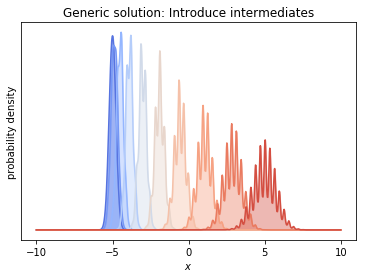

In [373]:
for i, lam in enumerate(np.linspace(0,1,10)):
    plt.plot(x,get_p(lam), color=colors[i])
    plt.fill_between(x, get_p(lam), alpha=0.4, color=colors[i])
plt.yticks([])
plt.ylabel("probability density")
plt.xticks(np.arange(-10, 11, 5))
plt.xlabel(r"$x$")
plt.title(r"Generic solution: Introduce intermediates")
plt.savefig("1_intermediates.jpg", dpi=300)

In [5]:
from scipy.stats import entropy

def get_D_KLs(lambda_sequence):
    """KL divergences between successive points in the sequence"""
    D_KLs = []
    for (lam_0, lam_1) in zip(lambda_sequence[:-1], lambda_sequence[1:]):
        D_KLs.append(entropy(get_p(lam_0), get_p(lam_1)))
    return D_KLs

def get_bias(lambda_sequence):
    """Sum of KL divergences between successive points in the sequence"""
    return np.sum(get_D_KLs(lambda_sequence))

(0, 0.0006676130929090528)

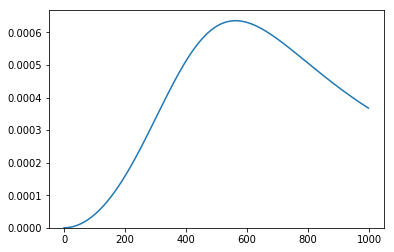

In [6]:
D_KLs = get_D_KLs(np.linspace(0,1,1000))
plt.plot(D_KLs)
plt.ylim(0,)

In [7]:
# okay cool! so let's see what happens if you just increase the number of intermediates:

from tqdm import tqdm
n_intermediates = np.arange(0, 1000)
all_D_KLs = []
for n in tqdm(n_intermediates):
    all_D_KLs.append(get_D_KLs(np.linspace(0, 1, 2 + n)))

100%|██████████| 1000/1000 [01:50<00:00,  4.73it/s]


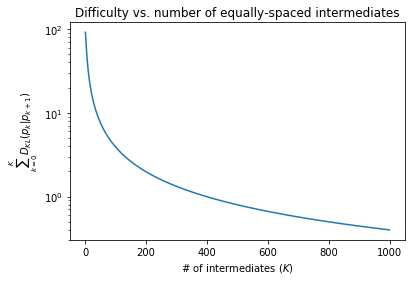

In [259]:
plt.plot([np.sum(D_KLs) for D_KLs in all_D_KLs])
plt.ylabel(r"$\sum_{k=0}^K D_{KL}(p_k \| p_{k+1})$")
plt.xlabel(r"# of intermediates ($K$)")
plt.yscale('log')
plt.title("Difficulty vs. number of equally-spaced intermediates")
plt.savefig("2_error_vs_path.jpg", dpi=300)

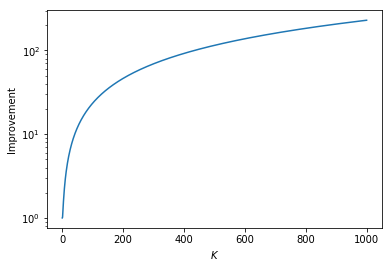

In [9]:
baseline = np.sum(all_D_KLs[0])

plt.plot([baseline / np.sum(D_KLs) for D_KLs in all_D_KLs])
plt.ylabel(r"Improvement")
plt.xlabel(r"$K$")
plt.yscale('log')

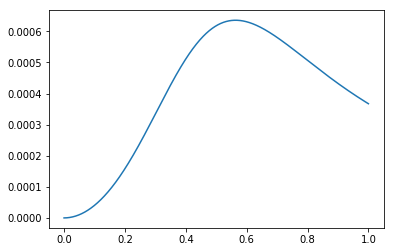

In [10]:
D_KLs = get_D_KLs(np.linspace(0,1,1000))
plt.plot(np.linspace(0,1,len(D_KLs)), D_KLs)

In [11]:
# in some regions, things are changing ~25x faster than in others...
# we would like to focus replicas in that region...
max(D_KLs) / min(D_KLs)

9993.0237620369007

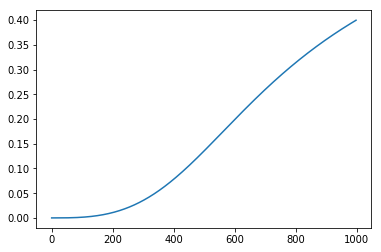

In [12]:
plt.plot(np.cumsum(D_KLs))

In [13]:
max(D_KLs) / min(D_KLs)

9993.0237620369007

In [253]:
X = []
for lam in tqdm(np.linspace(0,1,1002)):
    X.append(get_p(lam))
X = np.array(X)

100%|██████████| 1002/1002 [00:00<00:00, 10833.97it/s]


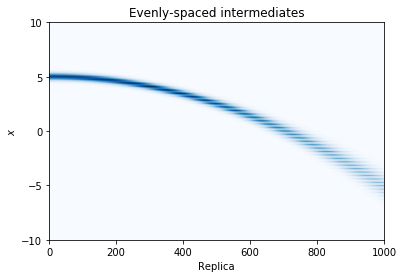

In [272]:
plt.imshow(X.T, extent=(0, 1000, -10,10), cmap="Blues", aspect="auto")
plt.xlabel("Replica")
plt.ylabel(r"$x$")
plt.yticks([-10,-5,0,5,10])
plt.title("Evenly-spaced intermediates")
plt.savefig("3_sequence_of_distributions.jpg", dpi=300)

(0, 95.560712080881302)

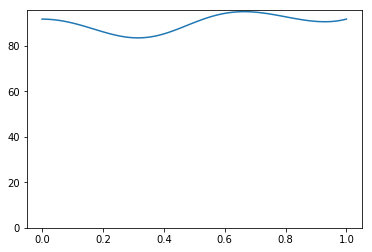

In [16]:
# so that's the linear spacing baseline: if we instead try to some binary search thing, can we get a better improvment?
    """Scan along to find a place to put a single intermediate
    
    TODO: replace with bisection or probabilistic bisection"""

    

def scan_for_intermediate_placement(lam_0, lam_1):
    badness = []
    lams = np.linspace(lam_0, lam_1, 100)
    for lam in lams:
        badness.append(np.sum(get_D_KLs([lam_0, lam, lam_1])))
    return lams, badness

plt.plot(*scan_for_intermediate_placement(0,1))
plt.ylim(0,)

In [17]:
lambda_sequences = [[0,1]]


intermediate_info = []

for i in tqdm(range(1000)):
    # find the most dissimilar p_k, p_k+1 pair
    lambda_sequence = lambda_sequences[-1]
    D_KLs = get_D_KLs(lambda_sequence)
    loc = np.argmax(D_KLs)
    
    # find the best new lambda to insert between them
    lams, badness = scan_for_intermediate_placement(lambda_sequence[loc], lambda_sequence[loc + 1])
    new_lam = lams[np.argmin(badness)]
    intermediate_info.append((lams, badness))
    
    # construct a new lambda sequence using the identified new lambda
    new_lam_sequence = list(lambda_sequence)
    new_lam_sequence.insert(loc+1, new_lam)
    lambda_sequences.append(new_lam_sequence)

100%|██████████| 1000/1000 [02:38<00:00,  3.48it/s]


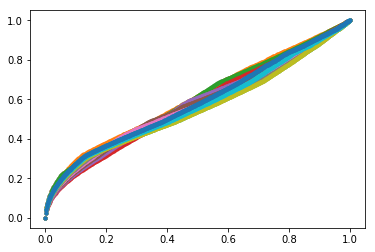

In [18]:
for l in lambda_sequences[::50]:
    plt.plot(np.linspace(0,1,len(l)), l, '.')

Linear protocol: max_k(D_KL(p_k || p_k+1)) / min_k(D_KL(p_k || p_k+1)) = 9993.688
Optimized protocol: max_k(D_KL(p_k || p_k+1)) / min_k(D_KL(p_k || p_k+1)) = 4.072


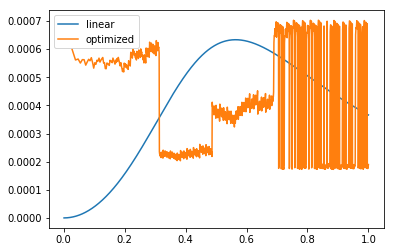

In [19]:
opt_lam_seq = lambda_sequences[-1]
linear_lam_seq = np.linspace(0,1,len(opt_lam_seq))

opt_D_KLs = get_D_KLs(opt_lam_seq)
linear_D_KLs = get_D_KLs(linear_lam_seq)

opt_max_over_min = max(opt_D_KLs) / min(opt_D_KLs)
linear_max_over_min = max(linear_D_KLs) / min(linear_D_KLs)

plt.plot(linear_lam_seq[1:], linear_D_KLs, label="linear")
print("Linear protocol: max_k(D_KL(p_k || p_k+1)) / min_k(D_KL(p_k || p_k+1)) = {:.3f}".format(linear_max_over_min))

plt.plot(opt_lam_seq[1:], opt_D_KLs, label="optimized")
print("Optimized protocol: max_k(D_KL(p_k || p_k+1)) / min_k(D_KL(p_k || p_k+1)) = {:.3f}".format(opt_max_over_min))

plt.legend()

In [20]:
linear_perf = np.array([np.sum(D_KLs) for D_KLs in all_D_KLs])
opt_perf = np.array([np.sum(get_D_KLs(lam_seq)) for lam_seq in tqdm(lambda_sequences)])

100%|██████████| 1001/1001 [01:48<00:00,  4.91it/s]


229.766221838 247.123741681


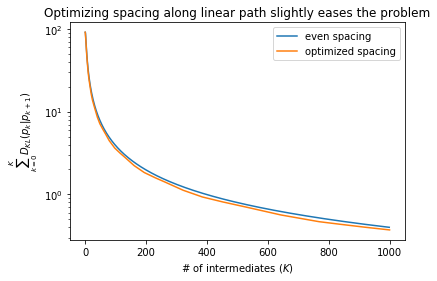

In [278]:
plt.plot(linear_perf, label="even spacing")
plt.plot(opt_perf, label="optimized spacing")

print(np.max(linear_perf[0] / linear_perf), np.max(opt_perf[0] / opt_perf))
plt.yscale('log')
plt.legend()
plt.ylabel(r"$\sum_{k=0}^K D_{KL}(p_k \| p_{k+1})$")
plt.title("Optimizing spacing along linear path slightly eases the problem")
plt.xlabel(r"# of intermediates ($K$)")
plt.savefig("4_optimized_spacing.jpg", dpi=300)

229.766221838 247.123741681


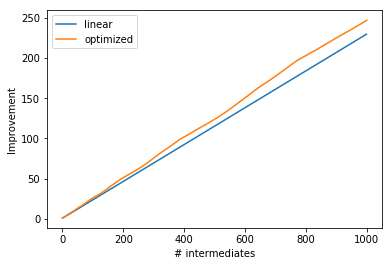

In [21]:
plt.plot(linear_perf[0] / linear_perf, label="even spacing")
plt.plot(opt_perf[0] / opt_perf, label="optimized spacing")

print(np.max(linear_perf[0] / linear_perf), np.max(opt_perf[0] / opt_perf))
#plt.yscale('log')
plt.legend()
plt.xlabel("# intermediates")
plt.ylabel("Improvement")
plt.title("Difficulty relative to 0 intermediates")

In [22]:
# now, what if we are instead able to do multi-dimensional optimization of the whole path
# instead of optimal spacing along a fixed 1D path...


def get_p_prime(lam_vec):
    q = np.exp(-u_prime(x, lam_vec))
    Z = np.trapz(q, x)
    p = q / Z
    return p

In [24]:
def loss_function(lambda_sequence):
    """Minimize this"""
    return np.sum([entropy(get_p_prime(lam0), get_p_prime(lam1))
                   for (lam0, lam1) in
                   zip(lambda_sequence[:-1], lambda_sequence[1:])])

In [25]:
linear_lambda_sequence = [lam * np.ones(3) for lam in np.linspace(0,1,11)]
loss_function(linear_lambda_sequence)

34.132440148658723

In [26]:
linear_lambda_sequence = [lam * np.ones(3) for lam in np.linspace(0,1,2)]
loss_function(linear_lambda_sequence)

91.715023235513399

In [27]:
from scipy.optimize import minimize

def find_best_intermediate(lam_vec_0, lam_vec_1):
    
    p0 = get_p_prime(lam_vec_0)
    p1 = get_p_prime(lam_vec_1)
    
    def fun(intermediate_lam_vec):
        p_intermediate = get_p_prime(intermediate_lam_vec)
        return entropy(p0, p_intermediate) + entropy(p_intermediate, p1)
    
    x0 = (np.array(lam_vec_0) + np.array(lam_vec_1)) / 2
    
    
    bounds = [(lam_vec_0[i], lam_vec_1[i]) for i in range(len(lam_vec_0))]
    result = minimize(fun, x0, bounds=bounds)
    return result

In [28]:
lam_vec_0 = np.zeros(3)
lam_vec_1 = np.ones(3)

result = find_best_intermediate(lam_vec_0, lam_vec_1)

In [29]:
result

      fun: 46.229478980210786
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.62900812e-05,  -8.09917474e+01,   8.78230821e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 56
      nit: 9
   status: 0
  success: True
        x: array([ 0.70710681,  1.        ,  0.4997658 ])

In [30]:
result.x

array([ 0.70710681,  1.        ,  0.4997658 ])

In [31]:
get_D_KLs([lam_vec_0, lam_vec_1])

[91.715023235513399]

In [32]:
lambda_vec_sequences = [[lam_vec_0, lam_vec_1]]

intermediate_info = []

for i in tqdm(range(1000)):
    # find the most dissimilar p_k, p_k+1 pair
    lambda_vec_sequence = lambda_vec_sequences[-1]
    D_KLs = get_D_KLs(lambda_vec_sequence)
    loc = np.argmax(D_KLs)
    
    # find the best new lambda_vec to insert between them
    result = find_best_intermediate(lambda_vec_sequence[loc], lambda_vec_sequence[loc + 1])
    new_lambda_vec = result.x
    intermediate_info.append(result)
    
    # construct a new lambda sequence using the identified new lambda
    new_lambda_vec_sequence = list(lambda_vec_sequence)
    new_lambda_vec_sequence.insert(loc+1, new_lambda_vec)
    lambda_vec_sequences.append(new_lambda_vec_sequence)

100%|██████████| 1000/1000 [01:47<00:00,  4.38it/s]


In [33]:
multi_D_perf = np.array([np.sum(get_D_KLs(sequence)) for sequence in lambda_vec_sequences])

In [34]:
min(linear_perf), min(opt_perf), min(multi_D_perf)

(0.39916669431089558, 0.37112995542869481, 0.11592693342778992)

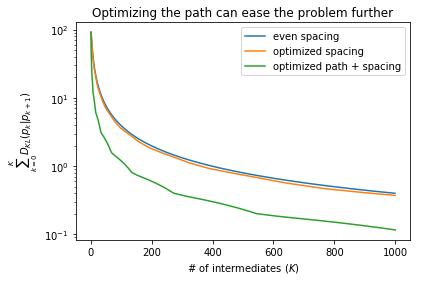

In [334]:
plt.plot(linear_perf, label="even spacing")
plt.plot(opt_perf, label="optimized spacing")
plt.plot(multi_D_perf, label="optimized path + spacing")
plt.yscale('log')
plt.legend()
plt.ylabel(r"$\sum_{k=0}^K D_{KL}(p_k \| p_{k+1})$")
plt.title("Optimizing the path can ease the problem further")
plt.xlabel(r"# of intermediates ($K$)")
plt.savefig("5_optimized_path.jpg", dpi=300)

In [36]:
multi_D_perf[20]

5.3910483549467276

In [37]:
# how many intermediates are required to reach a given error level?

np.interp(20.0, linear_perf, range(len(linear_perf)), )

999.0

In [38]:
np.mean(linear_perf), np.median(linear_perf)

(2.3571358549331971, 0.79630158474329216)

In [39]:
threshold = 0.8

np.argmax(linear_perf < threshold), np.argmax(opt_perf < threshold), np.argmax(multi_D_perf < threshold)

(498, 459, 136)

In [56]:
linear_perf[1:6], opt_perf[1:6], multi_D_perf[1:6]

(array([ 90.20893763,  76.88006696,  66.64625871,  57.96599922,  51.03975848]),
 array([ 83.46612368,  74.65867098,  63.99751188,  55.58214839,  48.65589714]),
 array([ 46.22947898,  34.85805554,  23.48688316,  20.64402651,  17.8011702 ]))

In [337]:
linear_replicas_required = []
opt_replicas_required = []
multi_D_replicas_required = []

thresholds = np.logspace(np.log10(min(linear_perf)), np.log10(max(linear_perf)), num=1000)[1:][::-1]

from scipy import interpolate
interp_linear = interpolate.interp1d(linear_perf, np.arange(len(linear_perf)))
interp_opt = interpolate.interp1d(opt_perf, np.arange(len(opt_perf)))
interp_multi_D = interpolate.interp1d(multi_D_perf, np.arange(len(multi_D_perf)))

for threshold in thresholds:
    linear_replicas_required.append(interp_linear(threshold))
    opt_replicas_required.append(interp_opt(threshold))
    multi_D_replicas_required.append(interp_multi_D(threshold))
linear_replicas_required = np.array(linear_replicas_required)
opt_replicas_required = np.array(opt_replicas_required)
multi_D_replicas_required = np.array(multi_D_replicas_required)

In [342]:
linear_replicas_required

array([  0.00000000e+00,   3.30528080e-01,   6.59262145e-01,
         9.86211933e-01,   1.03518495e+00,   1.07172845e+00,
         1.10807359e+00,   1.14422147e+00,   1.18017314e+00,
         1.21592968e+00,   1.25149214e+00,   1.28686158e+00,
         1.32203904e+00,   1.35702557e+00,   1.39182220e+00,
         1.42642997e+00,   1.46084989e+00,   1.49508300e+00,
         1.52913029e+00,   1.56299279e+00,   1.59667149e+00,
         1.63016739e+00,   1.66348148e+00,   1.69661476e+00,
         1.72956820e+00,   1.76234277e+00,   1.79493945e+00,
         1.82735921e+00,   1.85960300e+00,   1.89167179e+00,
         1.92356651e+00,   1.95528811e+00,   1.98683755e+00,
         2.02372481e+00,   2.06437104e+00,   2.10479666e+00,
         2.14500286e+00,   2.18499083e+00,   2.22476175e+00,
         2.26431681e+00,   2.30365718e+00,   2.34278402e+00,
         2.38169848e+00,   2.42040173e+00,   2.45889492e+00,
         2.49717917e+00,   2.53525562e+00,   2.57312541e+00,
         2.61078965e+00,

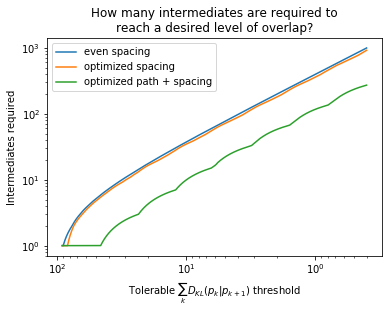

In [345]:
plt.figure()
ax = plt.subplot(111)
ax.plot(thresholds, np.maximum(1,linear_replicas_required), label="even spacing")
ax.plot(thresholds, np.maximum(1,opt_replicas_required), label="optimized spacing")
ax.plot(thresholds, np.maximum(1,multi_D_perf_replicas_required), label="optimized path + spacing")
ax.invert_xaxis()
plt.ylabel("Intermediates required")
plt.xlabel(r"Tolerable $\sum_k D_{KL}(p_k \| p_{k+1})$ threshold")
plt.yscale('log')
plt.xscale('log')
plt.title("How many intermediates are required to\nreach a desired level of overlap?")
plt.legend()
plt.savefig("6_num_replicas_required.jpg", dpi=300)

/Users/joshuafass/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


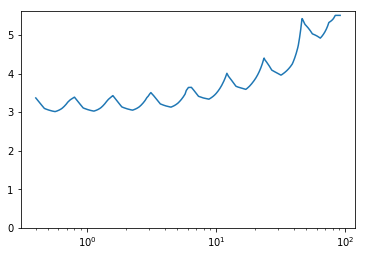

In [331]:
plt.plot(thresholds, np.array(opt_replicas_required) / np.array(multi_D_replicas_required))
plt.ylim(0,)
plt.xscale('log')

In [42]:
np.logspace(-0.1, 10)

array([  7.94328235e-01,   1.27679875e+00,   2.05231915e+00,
         3.29888630e+00,   5.30261134e+00,   8.52338773e+00,
         1.37004456e+01,   2.20220195e+01,   3.53980707e+01,
         5.68986603e+01,   9.14585875e+01,   1.47010021e+02,
         2.36303083e+02,   3.79832251e+02,   6.10540230e+02,
         9.81378942e+02,   1.57746301e+03,   2.53560519e+03,
         4.07571757e+03,   6.55128557e+03,   1.05304997e+04,
         1.69266662e+04,   2.72078283e+04,   4.37337106e+04,
         7.02973212e+04,   1.12995520e+05,   1.81628365e+05,
         2.91948415e+05,   4.69276246e+05,   7.54312006e+05,
         1.21247689e+06,   1.94892855e+06,   3.13269683e+06,
         5.03547932e+06,   8.09400122e+06,   1.30102522e+07,
         2.09126064e+07,   3.36148062e+07,   5.40322511e+07,
         8.68511374e+07,   1.39604031e+08,   2.24398737e+08,
         3.60697272e+08,   5.79782772e+08,   9.31939576e+08,
         1.49799445e+09,   2.40786788e+09,   3.87039333e+09,
         6.22124853e+09,

In [43]:
linear_perf

array([ 91.71502324,  90.20893763,  76.88006696,  66.64625871,
        57.96599922,  51.03975848,  45.48852773,  40.97620073,
        37.25151084,  34.13244015,  31.48606557,  29.21461487,
        27.24500744,  25.52160713,  24.00148959,  22.65093882,
        21.44323256,  20.3571143 ,  19.37526348,  18.48327008,
        17.6694275 ,  16.92407475,  16.23880623,  15.60667514,
        15.02184751,  14.47910906,  13.97414318,  13.50315051,
        13.06278736,  12.65020473,  12.26283018,  11.89844278,
        11.55505093,  11.23089633,  10.92440835,  10.63418272,
        10.35896057,  10.09760893,   9.84910635,   9.61252895,
         9.38703934,   9.17187664,   8.96634795,   8.76982097,
         8.58171748,   8.4015077 ,   8.22870534,   8.06286321,
         7.90356938,   7.75044379,   7.60313519,   7.4613185 ,
         7.32469239,   7.19297719,   7.06591294,   6.94325769,
         6.824786  ,   6.71028751,   6.59956575,   6.49243696,
         6.38872913,   6.28828104,   6.19094143,   6.09

In [44]:
np.min(linear_perf)

0.39916669431089558

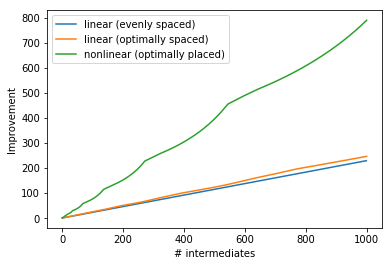

In [247]:
plt.plot(linear_perf[0] / linear_perf, label="linear (evenly spaced)")
plt.plot(opt_perf[0] / opt_perf, label="linear (optimally spaced)")
plt.plot(multi_D_perf[0] / multi_D_perf, label="nonlinear (optimally placed)")
#plt.yscale('log')
plt.legend()
plt.xlabel("# intermediates")
plt.ylabel("Improvement")

In [46]:
max(linear_perf[0] / linear_perf), max(opt_perf[0] / opt_perf), max(multi_D_perf[0] / multi_D_perf), 

(229.76622183833828, 247.12374168119285, 791.1450818514237)

(0, 0.0026710211513708199)

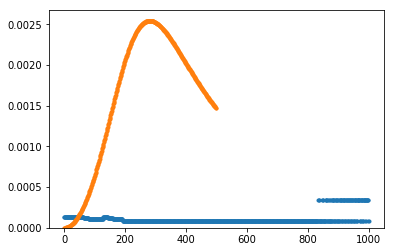

In [47]:
plt.plot(get_D_KLs(lambda_vec_sequence), '.')
plt.plot(get_D_KLs(np.linspace(0,1,500)), '.')

plt.ylim(0,)

In [349]:
X = []
for lam_vec in tqdm(lambda_vec_sequences[-1]):
    X.append(get_p_prime(lam_vec))
X = np.array(X)

100%|██████████| 1002/1002 [00:00<00:00, 13022.60it/s]


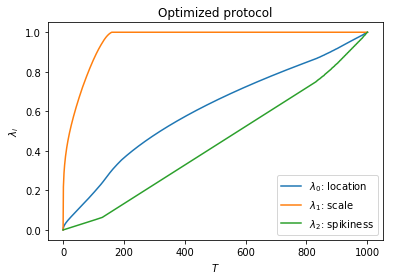

In [348]:
protocol = np.array(lambda_vec_sequences[-1])
for i in range(protocol.shape[1]):
    plt.plot(protocol[:,i], label=lambda_labels[i])
plt.legend()
plt.xlabel(r"$T$")
plt.ylabel(r"$\lambda_i$")
plt.title("Optimized protocol")
plt.savefig("7_optimized_protocol.jpg", dpi=300)

In [58]:
lambda_vec_sequences[-1][200]

array([ 0.36443439,  1.        ,  0.13272756])

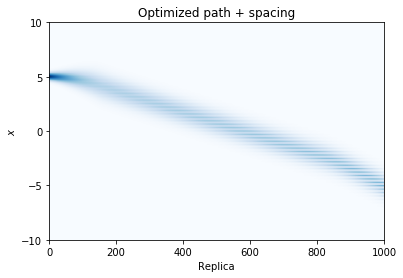

In [350]:
plt.imshow(X.T, extent=(0, 1000, -10,10), cmap="Blues", aspect="auto")
plt.xlabel("Replica")
plt.ylabel(r"$x$")
plt.yticks([-10,-5,0,5,10])
plt.title("Optimized path + spacing")
plt.savefig("8_optimized_sequence_of_distributions.jpg", dpi=300)

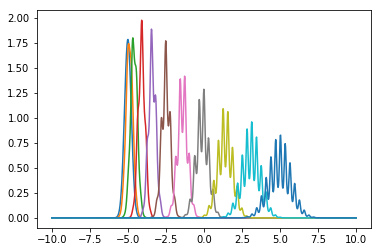

In [60]:
for lam in np.linspace(0,1,1002)[::100]:
    plt.plot(x,get_p(lam))

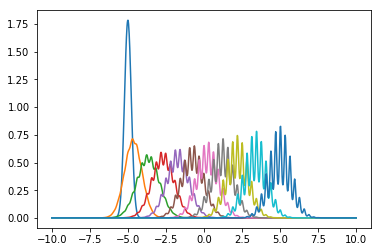

In [61]:
for lam_vec in lambda_vec_sequences[-1][::100]:
    plt.plot(x,get_p_prime(lam_vec))

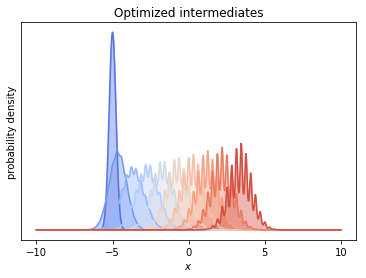

In [384]:
for i in range(10):
    lam_vec = lambda_vec_sequences[-1][::100][i]
    plt.plot(x,get_p_prime(lam_vec), color=colors[i])
    plt.fill_between(x, get_p_prime(lam_vec), alpha=0.4, color=colors[i])
plt.yticks([])
plt.ylabel("probability density")
plt.xticks(np.arange(-10, 11, 5))
plt.xlabel(r"$x$")
plt.title(r"Optimized intermediates")
plt.savefig("9_optimized_intermediates.jpg", dpi=300)

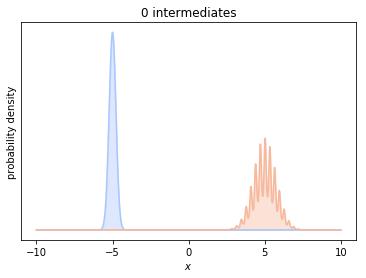

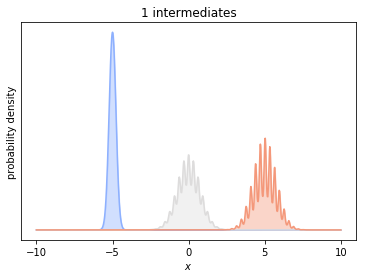

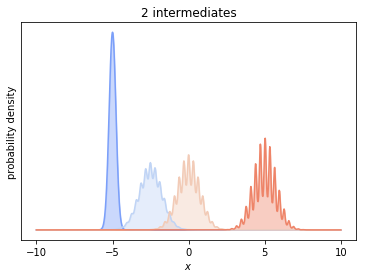

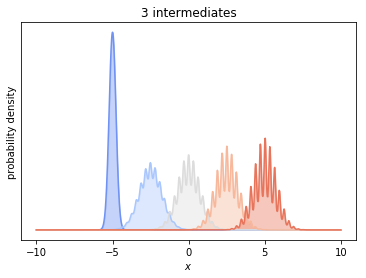

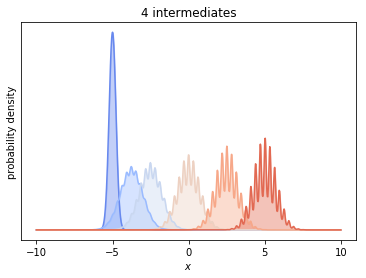

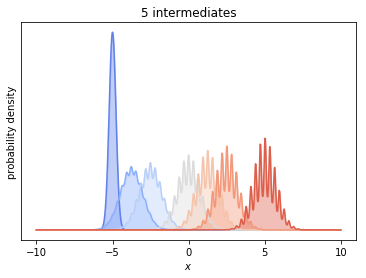

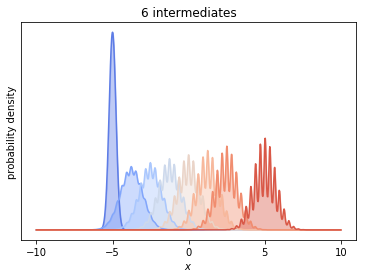

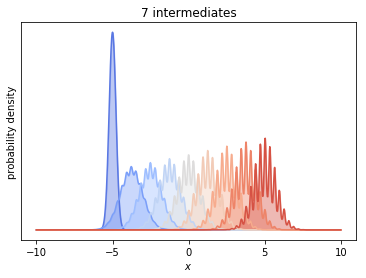

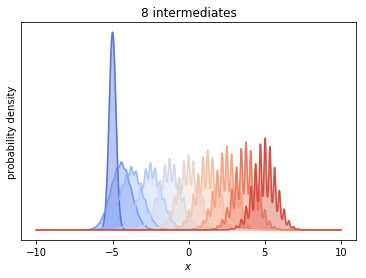

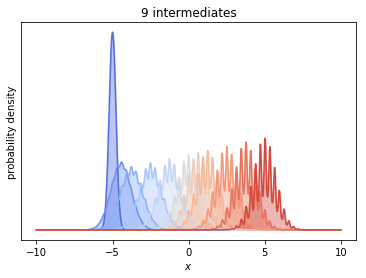

In [389]:
for k in range(10):
    plt.figure()
    
    colors = sns.color_palette("coolwarm", k+2)
    for i in range(k+2):
        lam_vec = lambda_vec_sequences[k][i]
        
        linestyle = None
        #if i == int((k+2) / 2):
        #    linestyle = "--"
        plt.plot(x,get_p_prime(lam_vec), color=colors[i], linestyle=linestyle)
        plt.fill_between(x, get_p_prime(lam_vec), alpha=0.4, color=colors[i])
    plt.yticks([])
    plt.ylabel("probability density")
    plt.xticks(np.arange(-10, 11, 5))
    plt.xlabel(r"$x$")
    plt.title("{} intermediates".format(k))

In [ ]:
lam_ve

In [376]:
len(lambda_vec_sequences[1])

3

## Next: doing this for toy biomolecular transformation from `alchemy`

In [68]:
from openmmtools import alchemy
from openmmtools.testsystems import AlanineDipeptideVacuum
testsystem = AlanineDipeptideVacuum()

In [70]:
factory = alchemy.AbsoluteAlchemicalFactory()
region = alchemy.AlchemicalRegion(alchemical_atoms=range(22), alchemical_bonds=True, alchemical_angles=True, alchemical_torsions=True)
alchemical_system = factory.create_alchemical_system(testsystem.system, region)

In [72]:
from simtk.openmm import app
from simtk import unit
from simtk import openmm as mm
from openmmtools.integrators import BAOABIntegrator

In [112]:
sim = app.Simulation(testsystem.topology, alchemical_system, BAOABIntegrator(measure_heat=False), platform=mm.Platform.getPlatformByName("Reference"))

In [113]:
sim.context.setPositions(testsystem.positions)
sim.context.setVelocitiesToTemperature(unit.kelvin * 298)

In [116]:
state = sim.context.getState(getParameterDerivatives=True)

In [117]:
map_string = state.getEnergyParameterDerivatives()
map_string.asdict()

{'lambda_angles': 0.0,
 'lambda_bonds': 0.0,
 'lambda_electrostatics': 0.0,
 'lambda_sterics': 0.0,
 'lambda_torsions': 0.0,
 'softcore_a': 0.0,
 'softcore_alpha': 0.0,
 'softcore_b': 0.0,
 'softcore_beta': 0.0,
 'softcore_c': 0.0,
 'softcore_d': 0.0,
 'softcore_e': 0.0,
 'softcore_f': 0.0}

In [118]:
param_names = list(map_string.asdict().keys())
for name in param_names:
    sim.context.setParameter(name, 0.5)

In [119]:
sim.context.getParameter(param_names[0])

0.5

In [123]:
state = sim.context.getState(getEnergy=True, getParameterDerivatives=True)
state.getEnergyParameterDerivatives().asdict()

{'lambda_angles': 0.0,
 'lambda_bonds': 0.0,
 'lambda_electrostatics': 0.0,
 'lambda_sterics': 0.0,
 'lambda_torsions': 0.0,
 'softcore_a': 0.0,
 'softcore_alpha': 0.0,
 'softcore_b': 0.0,
 'softcore_beta': 0.0,
 'softcore_c': 0.0,
 'softcore_d': 0.0,
 'softcore_e': 0.0,
 'softcore_f': 0.0}

In [168]:
state0 = {'lambda_angles': 0.0,
 'lambda_bonds': 0.0,
 'lambda_electrostatics': 0.0,
 'lambda_sterics': 0.0,
 'lambda_torsions': 0.0,
 'softcore_a': 0.0,
 'softcore_alpha': 0.0,
 'softcore_b': 0.0,
 'softcore_beta': 0.0,
 'softcore_c': 0.0,
 'softcore_d': 0.0,
 'softcore_e': 0.0,
 'softcore_f': 0.0}

for key in state0.keys():
    state0[key] = 0.1

state1 = dict(state0)
for key in state1.keys():
    state1[key] = 1.0

state0, state1

({'lambda_angles': 0.1,
  'lambda_bonds': 0.1,
  'lambda_electrostatics': 0.1,
  'lambda_sterics': 0.1,
  'lambda_torsions': 0.1,
  'softcore_a': 0.1,
  'softcore_alpha': 0.1,
  'softcore_b': 0.1,
  'softcore_beta': 0.1,
  'softcore_c': 0.1,
  'softcore_d': 0.1,
  'softcore_e': 0.1,
  'softcore_f': 0.1},
 {'lambda_angles': 1.0,
  'lambda_bonds': 1.0,
  'lambda_electrostatics': 1.0,
  'lambda_sterics': 1.0,
  'lambda_torsions': 1.0,
  'softcore_a': 1.0,
  'softcore_alpha': 1.0,
  'softcore_b': 1.0,
  'softcore_beta': 1.0,
  'softcore_c': 1.0,
  'softcore_d': 1.0,
  'softcore_e': 1.0,
  'softcore_f': 1.0})

In [169]:
state.getPotentialEnergy()

Quantity(value=-13.392680920532214, unit=kilojoule/mole)

In [170]:
%%time
sim.step(100)

CPU times: user 274 ms, sys: 26.4 ms, total: 301 ms
Wall time: 300 ms


In [183]:
from tqdm import tqdm


def set_state(state):
    for key, value in state.items():
        sim.context.setParameter(key, value)
        
def get_samples(state, thinning=100, n_samples=100, burn_in=10000):
    set_state(state)
    sim.context.setPositions(testsystem.positions)
    sim.context.setVelocitiesToTemperature(298 * unit.kelvin)
    
    samples = []
    
    for _ in tqdm(range(int(burn_in / 100))):
        sim.step(100)
    
    for i in tqdm(range(n_samples)):
        sim.step(thinning)
        samples.append(sim.context.getState(getPositions=True).getPositions(asNumpy=True))
    
    return samples

In [172]:
samples_from_lam_0 = get_samples(state0)
samples_from_lam_1 = get_samples(state1)

100%|██████████| 100/100 [00:03<00:00, 32.59it/s]


In [173]:
all_samples = samples_from_lam_0 + samples_from_lam_1

In [174]:
from openmmtools.constants import kB

In [175]:
# now let's construct the matrix required for pymbar

U_kn = np.zeros((2, len(all_samples)))

kBT = kB * 298 * unit.kelvin

set_state(state0)
for i in range(len(all_samples)):
    sim.context.setPositions(all_samples[i])
    U_kn[0, i] = sim.context.getState(getEnergy=True).getPotentialEnergy() / kBT
    
set_state(state1)
for i in range(len(all_samples)):
    sim.context.setPositions(all_samples[i])
    U_kn[1, i] = sim.context.getState(getEnergy=True).getPotentialEnergy() / kBT

In [176]:
U_kn[0]

array([  3.31078026,   1.71731916,   4.50502668,  10.12489757,
        12.33102229,   8.23919836,   5.58638327,   7.4501116 ,
         9.98241417,   9.99410188,  10.60593332,   8.61428262,
         5.19284396,   7.13838919,   5.63284165,   8.78621705,
        11.35496577,   7.71846995,   9.6549655 ,   6.84942374,
         5.52624308,   5.1614757 ,   9.83672396,  13.15448438,
         5.24383363,  -0.11368786,   7.45324951,   7.70918176,
         6.77087676,   9.68173519,   7.0651978 ,   6.74486435,
        11.51940669,   6.28438463,   5.65171166,  12.97648579,
        13.87621095,   8.35787801,   2.42498008,   5.95368053,
         9.5636718 ,   7.10959448,   4.58882274,   9.38134151,
         5.15003177,   3.53329765,   4.49849431,   6.10271379,
         7.73930286,   2.4370477 ,   0.93279206,   5.49209588,
         4.50082476,  -0.51638936,   5.41929228,   0.69045456,
         1.1531264 ,   6.8895033 ,   6.34703853,   4.55207176,
         7.99431756,   8.06587235,   8.41022667,  11.98

In [177]:
import pymbar
mbar = pymbar.MBAR(U_kn, [len(all_samples) / 2]*2)

In [178]:
mbar.f_k

array([  0.       ,  26.6771975])

In [179]:
mbar.getFreeEnergyDifferences()[:2]

(array([[  0.       ,  26.6771975],
        [-26.6771975,   0.       ]]),
 array([[       0.        ,  3373823.5525377 ],
        [ 3373388.93369551,        0.        ]]))

In [180]:
mbar.computeOverlap()

(4.6629367034256575e-15,
 array([ 1.,  1.]),
 matrix([[  1.00000000e+00,   1.66940062e-16],
         [  1.66940062e-16,   1.00000000e+00]]))

In [224]:
# linear protocol

all_samples = dict()
lams = np.linspace(0.0,1.0,100)
for lam in lams:
    print(lam)
    current_state = dict(state0)
    for key in current_state.keys():
        current_state[key] = lam
    
    
    samples = get_samples(current_state)
    all_samples[lam] = samples
    

  0%|          | 0/100 [00:00<?, ?it/s]

0.0


  0%|          | 0/100 [00:00<?, ?it/s]

0.010101010101


  0%|          | 0/100 [00:00<?, ?it/s]

0.020202020202


  0%|          | 0/100 [00:00<?, ?it/s]

0.030303030303


  0%|          | 0/100 [00:00<?, ?it/s]

0.040404040404


  0%|          | 0/100 [00:00<?, ?it/s]

0.0505050505051


  0%|          | 0/100 [00:00<?, ?it/s]

0.0606060606061


  0%|          | 0/100 [00:00<?, ?it/s]

0.0707070707071


  0%|          | 0/100 [00:00<?, ?it/s]

0.0808080808081


  0%|          | 0/100 [00:00<?, ?it/s]

0.0909090909091


  0%|          | 0/100 [00:00<?, ?it/s]

0.10101010101


  0%|          | 0/100 [00:00<?, ?it/s]

0.111111111111


  0%|          | 0/100 [00:00<?, ?it/s]

0.121212121212


  0%|          | 0/100 [00:00<?, ?it/s]

0.131313131313


  0%|          | 0/100 [00:00<?, ?it/s]

0.141414141414


  0%|          | 0/100 [00:00<?, ?it/s]

0.151515151515


  0%|          | 0/100 [00:00<?, ?it/s]

0.161616161616


  0%|          | 0/100 [00:00<?, ?it/s]

0.171717171717


  0%|          | 0/100 [00:00<?, ?it/s]

0.181818181818


  0%|          | 0/100 [00:00<?, ?it/s]

0.191919191919


  0%|          | 0/100 [00:00<?, ?it/s]

0.20202020202


  0%|          | 0/100 [00:00<?, ?it/s]

0.212121212121


  0%|          | 0/100 [00:00<?, ?it/s]

0.222222222222


  0%|          | 0/100 [00:00<?, ?it/s]

0.232323232323


  0%|          | 0/100 [00:00<?, ?it/s]

0.242424242424


  0%|          | 0/100 [00:00<?, ?it/s]

0.252525252525


  0%|          | 0/100 [00:00<?, ?it/s]

0.262626262626


  0%|          | 0/100 [00:00<?, ?it/s]

0.272727272727


  0%|          | 0/100 [00:00<?, ?it/s]

0.282828282828


  0%|          | 0/100 [00:00<?, ?it/s]

0.292929292929


  0%|          | 0/100 [00:00<?, ?it/s]

0.30303030303


  0%|          | 0/100 [00:00<?, ?it/s]

0.313131313131


  0%|          | 0/100 [00:00<?, ?it/s]

0.323232323232


  0%|          | 0/100 [00:00<?, ?it/s]

0.333333333333


  0%|          | 0/100 [00:00<?, ?it/s]

0.343434343434


  0%|          | 0/100 [00:00<?, ?it/s]

0.353535353535


  0%|          | 0/100 [00:00<?, ?it/s]

0.363636363636


  0%|          | 0/100 [00:00<?, ?it/s]

0.373737373737


  0%|          | 0/100 [00:00<?, ?it/s]

0.383838383838


  0%|          | 0/100 [00:00<?, ?it/s]

0.393939393939


  0%|          | 0/100 [00:00<?, ?it/s]

0.40404040404


  0%|          | 0/100 [00:00<?, ?it/s]

0.414141414141


  0%|          | 0/100 [00:00<?, ?it/s]

0.424242424242


  0%|          | 0/100 [00:00<?, ?it/s]

0.434343434343


  0%|          | 0/100 [00:00<?, ?it/s]

0.444444444444


  0%|          | 0/100 [00:00<?, ?it/s]

0.454545454545


  0%|          | 0/100 [00:00<?, ?it/s]

0.464646464646


  0%|          | 0/100 [00:00<?, ?it/s]

0.474747474747


  0%|          | 0/100 [00:00<?, ?it/s]

0.484848484848


  0%|          | 0/100 [00:00<?, ?it/s]

0.494949494949


  0%|          | 0/100 [00:00<?, ?it/s]

0.505050505051


  0%|          | 0/100 [00:00<?, ?it/s]

0.515151515152


  0%|          | 0/100 [00:00<?, ?it/s]

0.525252525253


  0%|          | 0/100 [00:00<?, ?it/s]

0.535353535354


  0%|          | 0/100 [00:00<?, ?it/s]

0.545454545455


  0%|          | 0/100 [00:00<?, ?it/s]

0.555555555556


  0%|          | 0/100 [00:00<?, ?it/s]

0.565656565657


  0%|          | 0/100 [00:00<?, ?it/s]

0.575757575758


  0%|          | 0/100 [00:00<?, ?it/s]

0.585858585859


  0%|          | 0/100 [00:00<?, ?it/s]

0.59595959596


  0%|          | 0/100 [00:00<?, ?it/s]

0.606060606061


  0%|          | 0/100 [00:00<?, ?it/s]

0.616161616162


  0%|          | 0/100 [00:00<?, ?it/s]

0.626262626263


  0%|          | 0/100 [00:00<?, ?it/s]

0.636363636364


  0%|          | 0/100 [00:00<?, ?it/s]

0.646464646465


  0%|          | 0/100 [00:00<?, ?it/s]

0.656565656566


  0%|          | 0/100 [00:00<?, ?it/s]

0.666666666667


  0%|          | 0/100 [00:00<?, ?it/s]

0.676767676768


  0%|          | 0/100 [00:00<?, ?it/s]

0.686868686869


  0%|          | 0/100 [00:00<?, ?it/s]

0.69696969697


  0%|          | 0/100 [00:00<?, ?it/s]

0.707070707071


  0%|          | 0/100 [00:00<?, ?it/s]

0.717171717172


  0%|          | 0/100 [00:00<?, ?it/s]

0.727272727273


  0%|          | 0/100 [00:00<?, ?it/s]

0.737373737374


  0%|          | 0/100 [00:00<?, ?it/s]

0.747474747475


  0%|          | 0/100 [00:00<?, ?it/s]

0.757575757576


  0%|          | 0/100 [00:00<?, ?it/s]

0.767676767677


  0%|          | 0/100 [00:00<?, ?it/s]

0.777777777778


  0%|          | 0/100 [00:00<?, ?it/s]

0.787878787879


  0%|          | 0/100 [00:00<?, ?it/s]

0.79797979798


  0%|          | 0/100 [00:00<?, ?it/s]

0.808080808081


  0%|          | 0/100 [00:00<?, ?it/s]

0.818181818182


  0%|          | 0/100 [00:00<?, ?it/s]

0.828282828283


  0%|          | 0/100 [00:00<?, ?it/s]

0.838383838384


  0%|          | 0/100 [00:00<?, ?it/s]

0.848484848485


  0%|          | 0/100 [00:00<?, ?it/s]

0.858585858586


  0%|          | 0/100 [00:00<?, ?it/s]

0.868686868687


  0%|          | 0/100 [00:00<?, ?it/s]

0.878787878788


  0%|          | 0/100 [00:00<?, ?it/s]

0.888888888889


  0%|          | 0/100 [00:00<?, ?it/s]

0.89898989899


  0%|          | 0/100 [00:00<?, ?it/s]

0.909090909091


  0%|          | 0/100 [00:00<?, ?it/s]

0.919191919192


  0%|          | 0/100 [00:00<?, ?it/s]

0.929292929293


  0%|          | 0/100 [00:00<?, ?it/s]

0.939393939394


  0%|          | 0/100 [00:00<?, ?it/s]

0.949494949495


  0%|          | 0/100 [00:00<?, ?it/s]

0.959595959596


  0%|          | 0/100 [00:00<?, ?it/s]

0.969696969697


  0%|          | 0/100 [00:00<?, ?it/s]

0.979797979798


  0%|          | 0/100 [00:00<?, ?it/s]

0.989898989899


  0%|          | 0/100 [00:00<?, ?it/s]

1.0


100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


In [226]:
concat_samples = []
for traj in all_samples.values():
    concat_samples.extend(traj)
len(concat_samples)

10000

In [227]:
U_kn = np.zeros((len(lams), len(concat_samples)))

for k, lam in enumerate(tqdm(lams)):
    current_state = dict(state0)
    for key in current_state.keys():
        current_state[key] = lam
        
    set_state(current_state)
    for n in range(len(concat_samples)):
        sim.context.setPositions(concat_samples[n])
        U_kn[k, n] = sim.context.getState(getEnergy=True).getPotentialEnergy() / kBT

100%|██████████| 100/100 [32:35<00:00, 18.04s/it]


In [232]:
U_kn_ = np.array(U_kn)
U_kn_.shape

(100, 10000)

In [234]:
U_kn = U_kn_[1:, len(all_samples[1.0]):]
U_kn.shape

(99, 9900)

In [236]:
mbar = pymbar.MBAR(U_kn, [len(all_samples[1.0])]*(len(lams) - 1))

In [237]:
mbar.f_k

array([  0.        ,  15.95014413,  25.53888408,  32.21905267,
        37.46880575,  41.82027205,  45.59065664,  48.92377551,
        51.88652365,  54.52245785,  56.87266958,  58.97875118,
        60.87866703,  62.60429161,  64.1816365 ,  65.63186149,
        66.97219807,  68.21671663,  69.37695913,  70.46243427,
        71.48099591,  72.43914528,  73.34228935,  74.19496725,
        75.00104264,  75.76385648,  76.48633893,  77.17108499,
        77.82040281,  78.43634424,  79.02072642,  79.57514998,
        80.10101734,  80.59955203,  81.07181913,  81.51874583,
        81.94114142,  82.33971582,  82.7150961 ,  83.06784072,
        83.39845151,  83.70738322,  83.99505109,  84.26183669,
        84.50809211,  84.73414308,  84.94029114,  85.12681512,
        85.29397215,  85.44199842,  85.5711097 ,  85.6815018 ,
        85.773351  ,  85.84681452,  85.90203103,  85.93912121,
        85.95818843,  85.95931947,  85.94258534,  85.90804221,
        85.85573244,  85.7856856 ,  85.69791977,  85.59

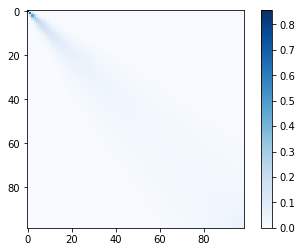

In [238]:
plt.imshow(mbar.computeOverlap()[-1], cmap="Blues")
plt.colorbar()

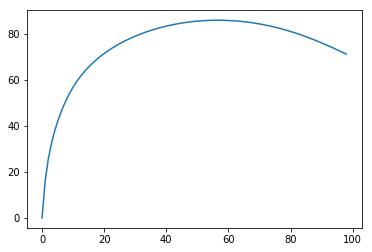

In [239]:
plt.plot(mbar.f_k)

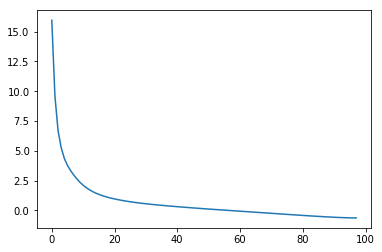

In [240]:
plt.plot(np.diff(mbar.f_k))

In [241]:
DF, dDF, _ = mbar.getFreeEnergyDifferences()

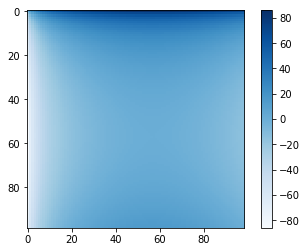

In [242]:
plt.imshow(DF, cmap="Blues")
plt.colorbar()

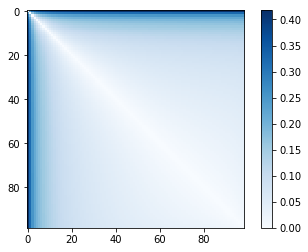

In [243]:
plt.imshow(dDF, cmap="Blues")
plt.colorbar()

In [380]:
mbar.computeOverlap() # wait what why are some of these imaginary

((0.026702678827597581+0j), array([  1.00000000e+00 +0.00000000e+00j,
          9.73297321e-01 +0.00000000e+00j,
          9.24441450e-01 +0.00000000e+00j,
          8.42329051e-01 +0.00000000e+00j,
          7.33375157e-01 +0.00000000e+00j,
          6.23132330e-01 +0.00000000e+00j,
          5.13544208e-01 +0.00000000e+00j,
          4.08685691e-01 +0.00000000e+00j,
          2.99750668e-01 +0.00000000e+00j,
          2.07325807e-01 +0.00000000e+00j,
          1.36818267e-01 +0.00000000e+00j,
          8.65349223e-02 +0.00000000e+00j,
          5.16353869e-02 +0.00000000e+00j,
          3.00951951e-02 +0.00000000e+00j,
          1.61819325e-02 +0.00000000e+00j,
          8.38413850e-03 +0.00000000e+00j,
          4.10431093e-03 +0.00000000e+00j,
          1.92412804e-03 +0.00000000e+00j,
          8.55410235e-04 +0.00000000e+00j,
          3.58739606e-04 +0.00000000e+00j,
          1.45001925e-04 +0.00000000e+00j,
          5.58604048e-05 +0.00000000e+00j,
          2.04529299e-05 +0

## Next: an efficient  `find_best_intermediate` solver for molecular systems, based on all previous samples + MBAR?

## Explanation / intuition
* Path optimization is a hard problem in general: at least as intractable as equilibrium sampling
* We have to optimize over a sequence of $N$-dimensional lambda vectors $\text{protocol} = (\lambda_1, \lambda_2, \dots, \lambda_T)$ which is a $TN$-dimensional search space.
* Here, we break the problem into a sequence of $T$ optimization problems over $N$-dimensional search spaces. The method also provides a sequence of protocols of varying length.



#### Warm-up: Accept a pre-defined continuous path, and just determine spacing of discrete replicas along that path.
* Baseline: Linear spacing
* Slightly better: Argmin within "worst" segment

#### Full problem: Optimize over multi-dimensional protocols.
* Proposed: Argmin within "worst" box
